In [1]:
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.feature import Bucketizer, StringIndexer,VectorAssembler, IndexToString
from pyspark.ml.classification import DecisionTreeClassifier,DecisionTreeClassificationModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.param import TypeConverters
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, IntegerType, StringType
from pyspark.ml.feature import HashingTF, Tokenizer, IDF, StopWordsRemover, Binarizer,RegexTokenizer
from pyspark.ml.feature import SQLTransformer
import re
from pyspark.ml.param import TypeConverters
from pyspark.ml.classification import NaiveBayes, NaiveBayesModel, RandomForestClassifier,RandomForestClassificationModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit

In [2]:
reviews= spark.read.csv("C:/Users/bojha/Documents/GL/Reviews.csv", header = True, inferSchema = True)

This dataset consists of a single CSV file, Reviews.csv, and a corresponding SQLite table named Reviews in database.sqlite. The columns in the table are:
•	Id
•	ProductId - unique identifier for the product
•	UserId - unqiue identifier for the user
•	ProfileName
•	HelpfulnessNumerator - number of users who found the review helpful
•	HelpfulnessDenominator - number of users who indicated whether they found the review helpful
•	Score - rating between 1 and 5. (/nitin  Ratings are 
•	Time - timestamp for the review
•	Summary - brief summary of the review
•	Text - text of the review

In [3]:
reviews.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- ProductId: string (nullable = true)
 |-- UserId: string (nullable = true)
 |-- ProfileName: string (nullable = true)
 |-- HelpfulnessNumerator: string (nullable = true)
 |-- HelpfulnessDenominator: string (nullable = true)
 |-- Score: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Summary: string (nullable = true)
 |-- Text: string (nullable = true)



In [4]:
reviews.count()

568361

In [5]:
rd = reviews.withColumn("Score", reviews["Score"].cast("double")).withColumn("HelpfulnessNumerator", reviews["HelpfulnessNumerator"].cast("double"))

In [6]:
rd= rd.withColumn("HelpfulnessDenominator", rd["HelpfulnessDenominator"].cast("double")).dropna()

In [7]:
rd.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- ProductId: string (nullable = true)
 |-- UserId: string (nullable = true)
 |-- ProfileName: string (nullable = true)
 |-- HelpfulnessNumerator: double (nullable = true)
 |-- HelpfulnessDenominator: double (nullable = true)
 |-- Score: double (nullable = true)
 |-- Time: string (nullable = true)
 |-- Summary: string (nullable = true)
 |-- Text: string (nullable = true)



In [8]:
reviews.count()

568361

In [9]:
rd.count()

565620

Thus, we had about 3000 observations with na values which we have removed now. 

In [10]:
rd.take(1)

[Row(Id=1, ProductId=u'B001E4KFG0', UserId=u'A3SGXH7AUHU8GW', ProfileName=u'delmartian', HelpfulnessNumerator=1.0, HelpfulnessDenominator=1.0, Score=5.0, Time=u'1303862400', Summary=u'Good Quality Dog Food', Text=u'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.')]

Thus, we see that the first observation is about product ID B001E$KFG0 (hiding the actual product from us, which is case often)  from the user A3SGXH7AUHU8GW with profile name delmartian. He is talking about good quality Dog Food at time 1303862400 and has given it a score of 5. The summary as given by him is 'Good Quality Dog Food'. The actual text of his review is in the Text column and on reading, it sounds positive. The words which indicate positive senses are: smell better, good quality, appreciates this product better than most etc. Our task is to create a sentiment score of these reviews and see how wel they correlate with the Score which the reviewer has himself given. Please note that they need not always match. 

In [11]:
rd.toPandas().describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score
count,565620.000000,565620.000000,565620.000000,565620.000000
mean,284277.684311,1.740548,2.225347,4.183227
std,164102.573640,7.642087,8.294381,1.311098
min,1.000000,0.000000,0.000000,1.000000
25%,142199.750000,0.000000,0.000000,4.000000
50%,284309.500000,0.000000,1.000000,5.000000
75%,426392.250000,2.000000,2.000000,5.000000
max,568454.000000,866.000000,923.000000,5.000000


Here, we see that HelpfulnessNumerator ranges from 0 to 866 with 50% percentile having value less than 0 and mean value of 1.74. HelpfulnesssDenominator ranges from 0 to 923 with 25% having value of 0 and mean of 2.22.  For Score, we have values ranging from 1 to 5 with 75% scoring more than 4 and more than 50% scoring 5. Thus, we have a positive bias in the reviews. This will mean that we will have difficulty in predicting negative reviews and our model will be more inclined to predict a review a positive. There are several ways to address this. One of the popular ways is to sample the data so that the training data has equal representation of the negative and positive biases.

In [12]:
rd.groupBy("Score").count().sort("Score").show(100)

+-----+------+
|Score| count|
+-----+------+
|  1.0| 52114|
|  2.0| 29594|
|  3.0| 42353|
|  4.0| 80039|
|  5.0|361520|
+-----+------+



In [14]:
36.0/56.0

0.6428571428571429

In [15]:
44.0/56.0

0.7857142857142857

Now, we have exact numbers of reviews at various scores levels:  we see that about 65% of the reviews have scored themselves at 5 and about 80% are above or equal to 4. This is indeed a very positive corpus. 

In  the below, we calculate the helpfulness score as suggested by the creator of the dataset and correlate that with the "Score".

In [16]:
rd1= rd.withColumn("helpfulness", rd.HelpfulnessDenominator/rd.HelpfulnessNumerator)

In [17]:
rd1.show(1)

+---+----------+--------------+-----------+--------------------+----------------------+-----+----------+--------------------+--------------------+-----------+
| Id| ProductId|        UserId|ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|             Summary|                Text|helpfulness|
+---+----------+--------------+-----------+--------------------+----------------------+-----+----------+--------------------+--------------------+-----------+
|  1|B001E4KFG0|A3SGXH7AUHU8GW| delmartian|                 1.0|                   1.0|  5.0|1303862400|Good Quality Dog ...|I have bought sev...|        1.0|
+---+----------+--------------+-----------+--------------------+----------------------+-----+----------+--------------------+--------------------+-----------+
only showing top 1 row



In [18]:
rd1.select("helpfulness").toPandas().describe()

,helpfulness
count,263205.000000
mean,1.347532
std,1.196530
min,0.333333
25%,1.000000
50%,1.000000
75%,1.250000
max,91.000000


In [20]:
rd1.corr("helpfulness","Score")

-0.2173824300531092

Thus, we see that the helpfulness score is negatively correlated to the Score as it is not running as high as the "score". 

In [19]:
rd1.cov("helpfulness","Score")

-0.3013559814229622

Let's use matplotlib to plot the relationship between helpfulness and score to further understand what is happening?

In [21]:
from matplotlib import *
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
rd1PD=rd1.toPandas()

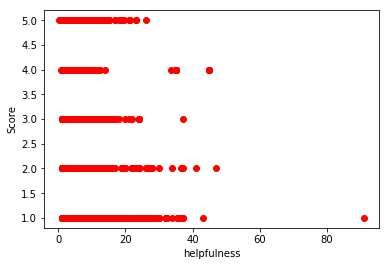

In [24]:
plt.plot(rd1PD['helpfulness'], rd1PD['Score'],'ro')
plt.xlabel('helpfulness')
plt.ylabel('Score')
plt.show()

We see that at all levels of score values, helpfulness is nearly same with infact slightly lower values for higher values of 4 and 5, thus indicating lower correlations between two variables.

In [29]:
rd1PD['Text']

0         I have bought several of the Vitality canned d...
1         "Product arrived labeled as Jumbo Salted Peanu...
2         "This is a confection that has been around a f...
3         If you are looking for the secret ingredient i...
4         Great taffy at a great price.  There was a wid...
5         I got a wild hair for taffy and ordered this f...
6         This saltwater taffy had great flavors and was...
7         This taffy is so good.  It is very soft and ch...
8         Right now I'm mostly just sprouting this so my...
9         This is a very healthy dog food. Good for thei...
10        I don't know if it's the cactus or the tequila...
11        One of my boys needed to lose some weight and ...
12        My cats have been happily eating Felidae Plati...
13        good flavor! these came securely packed... the...
14        The Strawberry Twizzlers are my guilty pleasur...
15        My daughter loves twizzlers and this shipment ...
16        I love eating them and they ar

In the above we see a stripped off version of revews. In order to see full review for a given row, let's do the following:

In [30]:
rd1PD["Text"][0]

u'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

We see a very positive example of the review here. Let's see one more example.

In [32]:
rd1PD["Text"][1]

u'"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."'

On reading, this is clearly a negative review. But, since the negativity here is more like 'irony', it will be quite challenging to see if the algorithm is able to actually give out a negative score to this review.

In both examples above, we are able to find the review to be negative or positive because of the words we recognise. For example, in the first review, words like 'better', 'good' tell us that the review is positive. imilarly, in the second example, words like 'small' and 'error' are suggesting this to be negtive review.  Thus, these words are our features which we need to extract for each review and then use the information contained in them to assess the sentiment of each review. This is what we intend to do below.

In [33]:
rd.select("Text").show(5)

+--------------------+
|                Text|
+--------------------+
|I have bought sev...|
|"Product arrived ...|
|"This is a confec...|
|If you are lookin...|
|Great taffy at a ...|
+--------------------+
only showing top 5 rows



In [19]:
rd.select("UserId").distinct().count()

255327

In [34]:
rd.count()

565620

In [36]:
565620.0/255327.0

2.215276880235933

In [20]:
rd.select("ProductId").distinct().count()

74124

In [37]:
565620.0/74124.0

7.6307268900760885

Thus, we have 255327 distinct users who have written reviews about 74124 products. There are about 7.6 reviews per product and each user has written about 2.2 reviews.

In [38]:
type(rd1)

pyspark.sql.dataframe.DataFrame

In [39]:
rd1.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- ProductId: string (nullable = true)
 |-- UserId: string (nullable = true)
 |-- ProfileName: string (nullable = true)
 |-- HelpfulnessNumerator: double (nullable = true)
 |-- HelpfulnessDenominator: double (nullable = true)
 |-- Score: double (nullable = true)
 |-- Time: string (nullable = true)
 |-- Summary: string (nullable = true)
 |-- Text: string (nullable = true)
 |-- helpfulness: double (nullable = true)



Create a feature transformer for stopwords removing using default stopwords list for english

In [40]:
rd1.show(3)

+---+----------+--------------+--------------------+--------------------+----------------------+-----+----------+--------------------+--------------------+-----------+
| Id| ProductId|        UserId|         ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|             Summary|                Text|helpfulness|
+---+----------+--------------+--------------------+--------------------+----------------------+-----+----------+--------------------+--------------------+-----------+
|  1|B001E4KFG0|A3SGXH7AUHU8GW|          delmartian|                 1.0|                   1.0|  5.0|1303862400|Good Quality Dog ...|I have bought sev...|        1.0|
|  2|B00813GRG4|A1D87F6ZCVE5NK|              dll pa|                 0.0|                   0.0|  1.0|1346976000|   Not as Advertised|"Product arrived ...|       null|
|  3|B000LQOCH0| ABXLMWJIXXAIN|"Natalia Corres "...|                 1.0|                   1.0|  4.0|1219017600|"""Delight"" says...|"This is a confec...|     

Now, we tokenize the text of the review into individual words, which will become our features to help us score them on the positivity of the review. In the below, we are taking the "Text" column and breaking this into vector of "words".  We are using the RegexTokenizer function of the MLlib which extract tokens by using the regular expression pattern (or default which is space). I first create the call.

In [41]:
reTokenizer = RegexTokenizer(inputCol="Text", outputCol="words")

Now, I apply it on the rd1 dataset.

In [42]:
rd11= reTokenizer.transform(rd1)

In [74]:
rd11.select("Text","words").show()

+--------------------+--------------------+
|                Text|               words|
+--------------------+--------------------+
|I have bought sev...|[i, have, bought,...|
|"Product arrived ...|["product, arrive...|
|"This is a confec...|["this, is, a, co...|
|If you are lookin...|[if, you, are, lo...|
|Great taffy at a ...|[great, taffy, at...|
|I got a wild hair...|[i, got, a, wild,...|
|This saltwater ta...|[this, saltwater,...|
|This taffy is so ...|[this, taffy, is,...|
|Right now I'm mos...|[right, now, i'm,...|
|This is a very he...|[this, is, a, ver...|
|I don't know if i...|[i, don't, know, ...|
|One of my boys ne...|[one, of, my, boy...|
|My cats have been...|[my, cats, have, ...|
|good flavor! thes...|[good, flavor!, t...|
|The Strawberry Tw...|[the, strawberry,...|
|My daughter loves...|[my, daughter, lo...|
|I love eating the...|[i, love, eating,...|
|I am very satisfi...|[i, am, very, sat...|
|Twizzlers, Strawb...|[twizzlers,, stra...|
|Candy was deliver...|[candy, wa

Here we see that the sentences are broken into individual words. For example the sentence "I have bought several..." has been split into a vector ["i", "have", "bought"...] etc.

Next step is to remove th trivial words like 'is''are' etc from the tokens as they do not help us learn about the sentiments of the review. pyspark again provides a builtin utility to handle that called StopWordsRemover. Here, I am using the default list of stopwords but you can also supply your own stop words list.

In [43]:
stopword= StopWordsRemover(inputCol="words", outputCol="cText")

In [44]:
rd12=stopword.transform(rd11)

In [75]:
rd12.select("words","cText").show(5)

+--------------------+--------------------+
|               words|               cText|
+--------------------+--------------------+
|[i, have, bought,...|[bought, several,...|
|["product, arrive...|["product, arrive...|
|["this, is, a, co...|["this, confectio...|
|[if, you, are, lo...|[looking, secret,...|
|[great, taffy, at...|[great, taffy, gr...|
+--------------------+--------------------+
only showing top 5 rows



Thus,we see that words like 'i', 'is', 'are' etc. have been removed.

In [46]:
rd12.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- ProductId: string (nullable = true)
 |-- UserId: string (nullable = true)
 |-- ProfileName: string (nullable = true)
 |-- HelpfulnessNumerator: double (nullable = true)
 |-- HelpfulnessDenominator: double (nullable = true)
 |-- Score: double (nullable = true)
 |-- Time: string (nullable = true)
 |-- Summary: string (nullable = true)
 |-- Text: string (nullable = true)
 |-- helpfulness: double (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- cText: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [47]:
rd13 = rd12.select ('Score',rd12.cText.cast(StringType())) 

In [48]:
rd13.printSchema()

root
 |-- Score: double (nullable = true)
 |-- cText: string (nullable = true)



In [49]:
rd13.show()

+-----+--------------------+
|Score|               cText|
+-----+--------------------+
|  5.0|[bought,several,v...|
|  1.0|["product,arrived...|
|  4.0|["this,confection...|
|  2.0|[looking,secret,i...|
|  5.0|[great,taffy,grea...|
|  4.0|[got,wild,hair,ta...|
|  5.0|[saltwater,taffy,...|
|  5.0|[taffy,good.,soft...|
|  5.0|[right,i'm,mostly...|
|  5.0|[healthy,dog,food...|
|  5.0|[don't,know,it's,...|
|  5.0|[one,boys,needed,...|
|  1.0|[cats,happily,eat...|
|  4.0|[good,flavor!,cam...|
|  5.0|[strawberry,twizz...|
|  5.0|[daughter,loves,t...|
|  2.0|[love,eating,good...|
|  5.0|[satisfied,twizzl...|
|  5.0|[twizzlers,,straw...|
|  5.0|[candy,delivered,...|
+-----+--------------------+
only showing top 20 rows



Create the tokenizer

In [50]:
tokenize= Tokenizer(inputCol="cText", outputCol="tokens")

In [51]:
rd2=tokenize.transform(rd13)

In [52]:
rd2.show()

+-----+--------------------+--------------------+
|Score|               cText|              tokens|
+-----+--------------------+--------------------+
|  5.0|[bought,several,v...|[[bought,several,...|
|  1.0|["product,arrived...|[["product,arrive...|
|  4.0|["this,confection...|[["this,confectio...|
|  2.0|[looking,secret,i...|[[looking,secret,...|
|  5.0|[great,taffy,grea...|[[great,taffy,gre...|
|  4.0|[got,wild,hair,ta...|[[got,wild,hair,t...|
|  5.0|[saltwater,taffy,...|[[saltwater,taffy...|
|  5.0|[taffy,good.,soft...|[[taffy,good.,sof...|
|  5.0|[right,i'm,mostly...|[[right,i'm,mostl...|
|  5.0|[healthy,dog,food...|[[healthy,dog,foo...|
|  5.0|[don't,know,it's,...|[[don't,know,it's...|
|  5.0|[one,boys,needed,...|[[one,boys,needed...|
|  1.0|[cats,happily,eat...|[[cats,happily,ea...|
|  4.0|[good,flavor!,cam...|[[good,flavor!,ca...|
|  5.0|[strawberry,twizz...|[[strawberry,twiz...|
|  5.0|[daughter,loves,t...|[[daughter,loves,...|
|  2.0|[love,eating,good...|[[love,eating,goo...|


Now, we will compute how many times each token occures in a particular review by counting its frequency in the document. This we will do for top 400 words which occur in our reviews. This will remove a lot of words which occur only once or twice and may not play significant role in determining the sentiment. This is a very important number and one should play with different values of it to see how does the performanc evary. 
Create HashingTF

In [53]:
hashingTF = HashingTF(inputCol="tokens", outputCol="rawFeatures", numFeatures=400)

In [54]:
hashingTF.getOrDefault("outputCol")

'rawFeatures'

In [55]:
rd3=hashingTF.transform(rd2)

In [56]:
rd3.show()

+-----+--------------------+--------------------+-----------------+
|Score|               cText|              tokens|      rawFeatures|
+-----+--------------------+--------------------+-----------------+
|  5.0|[bought,several,v...|[[bought,several,...|(400,[105],[1.0])|
|  1.0|["product,arrived...|[["product,arrive...| (400,[77],[1.0])|
|  4.0|["this,confection...|[["this,confectio...| (400,[17],[1.0])|
|  2.0|[looking,secret,i...|[[looking,secret,...| (400,[52],[1.0])|
|  5.0|[great,taffy,grea...|[[great,taffy,gre...|(400,[326],[1.0])|
|  4.0|[got,wild,hair,ta...|[[got,wild,hair,t...|(400,[275],[1.0])|
|  5.0|[saltwater,taffy,...|[[saltwater,taffy...|(400,[362],[1.0])|
|  5.0|[taffy,good.,soft...|[[taffy,good.,sof...|(400,[350],[1.0])|
|  5.0|[right,i'm,mostly...|[[right,i'm,mostl...|(400,[162],[1.0])|
|  5.0|[healthy,dog,food...|[[healthy,dog,foo...|(400,[328],[1.0])|
|  5.0|[don't,know,it's,...|[[don't,know,it's...|(400,[345],[1.0])|
|  5.0|[one,boys,needed,...|[[one,boys,needed...

In the above, we see that the word 'bought' is 106th term in th token vector and its frequncy in the first document is 1. In fact, most terms seem to have a frequency of 1.

Next, we calculate the 'Inverse Document Frequecy' or IDF. This is one of the most important concept in text mining and it helps us identify terms which are important from the unimpotant ones.Terms which are occuring in all documents will not help us identify when should the sentiment be positive or not. Thus, this term gives weightages to terms which occur in fewer documents.

In [57]:
idf = IDF(inputCol="rawFeatures", outputCol="features")

Apply IDF to the raw features and rescale the data

In [58]:
idfModel= idf.fit(rd3)

In [59]:
rescaledData = idfModel.transform(rd3)

In [60]:
rescaledData.show(2)

+-----+--------------------+--------------------+-----------------+--------------------+
|Score|               cText|              tokens|      rawFeatures|            features|
+-----+--------------------+--------------------+-----------------+--------------------+
|  5.0|[bought,several,v...|[[bought,several,...|(400,[105],[1.0])|(400,[105],[5.962...|
|  1.0|["product,arrived...|[["product,arrive...| (400,[77],[1.0])|(400,[77],[5.9074...|
+-----+--------------------+--------------------+-----------------+--------------------+
only showing top 2 rows



Thus feature venctor carrying the values of IDF of terms is our final feature vector which will be used to train the model which will help us score the reviews on their positivity.

In [61]:
train, test = rescaledData.randomSplit([0.8, 0.2], seed=12345)

In [62]:
nb= NaiveBayes(smoothing=1.0,labelCol="Score",  modelType="multinomial")

In [63]:
cc=train.groupBy("Score").count().show()

+-----+------+
|Score| count|
+-----+------+
|  1.0| 41736|
|  4.0| 63952|
|  3.0| 33825|
|  2.0| 23610|
|  5.0|289215|
+-----+------+



In [64]:
train.filter(train.Score == 1).count()

41736

In [65]:
train.count()

452338

In [66]:
nb_model=nb.fit(train)

In [67]:
type(nb_model)

pyspark.ml.classification.NaiveBayesModel

In [69]:
nb_model.uid

u'NaiveBayes_4539ac43c3432442aab2'

In [70]:
result_nb=nb_model.transform(test)\
    .select("features", "Score", "prediction")

In [71]:
ct=result_nb.crosstab("Score","prediction")

In [72]:
ct.show()

+----------------+----+---+---+----+-----+
|Score_prediction| 0.0|1.0|2.0| 3.0|  4.0|
+----------------+----+---+---+----+-----+
|             5.0|2134|727|545|1925|66974|
|             1.0| 433|103| 88| 306| 9448|
|             2.0| 166| 83| 43| 161| 5531|
|             3.0| 242| 71| 70| 224| 7921|
|             4.0| 485|145|139| 559|14759|
+----------------+----+---+---+----+-----+



Thus, we get the model to predict a large number of '5's as we had suspected during the EDA. Further tasks will be further tune the model by looking at various alternate algorithms like SVM, Logistics Regression etc, come up with various kinds of features like for example we have not taken into consideraiton the 'summary' column and so on. The possibilities are enourmous and I will encourage you to use your creativity and try different combinations to see of you can come up with a model which will score better that the above model.